### Read in OverSampled data

In [1]:
import time
import pandas as pd
import dask.dataframe as dd
import numpy as np
import feather
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
from sklearn.metrics import *
from imblearn.metrics import classification_report_imbalanced
import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
import configparser
import ast
import pickle
import sys
from multiprocessing import Pool, Process
import warnings
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

config = configparser.ConfigParser()

config_path = config.read('/home/melgazar9/Trading/TD/Scripts/Trading-Scripts/CL/scripts/CL_10min_TRAIN-MODEL.ini'.format(sys.argv[1]))

print('**************** RUNNING', config['NAME']['product'], ' ****************')

train_start_date = config['PARAMS']['train_start_date']
train_end_date = config['PARAMS']['train_end_date']
val_start_date = config['PARAMS']['val_start_date']
val_end_date = config['PARAMS']['val_end_date']
test_start_date = config['PARAMS']['test_start_date']

threshold = float(config['PARAMS']['threshold'])
multiplier = float(config['PARAMS']['multiplier'])

strong_buy_actual = float(config['PARAMS']['strong_buy_actual'])
med_buy_actual = float(config['PARAMS']['med_buy_actual'])
no_trade_actual = float(config['PARAMS']['no_trade_actual'])
med_sell_actual = float(config['PARAMS']['med_sell_actual'])
strong_sell_actual = float(config['PARAMS']['strong_sell_actual'])
stop_actual = float(config['PARAMS']['stop_actual'])

strong_buy_HL = float(config['PARAMS']['strong_buy_HL'])
med_buy_HL = float(config['PARAMS']['med_buy_HL'])
no_trade_HL = float(config['PARAMS']['no_trade_HL'])
med_sell_HL = float(config['PARAMS']['med_sell_HL'])
strong_sell_HL = float(config['PARAMS']['strong_sell_HL'])
stop_HL = float(config['PARAMS']['stop_HL'])

strong_cap_actual = float(config['PARAMS']['strong_cap_actual'])
med_cap_actual = float(config['PARAMS']['med_cap_actual'])
strong_cap_HL = float(config['PARAMS']['strong_cap_HL'])
med_cap_HL = float(config['PARAMS']['med_cap_actual'])

min_prob0 = float(config['PARAMS']['min_prob0'])
min_prob1 = float(config['PARAMS']['min_prob1'])
min_prob3 = float(config['PARAMS']['min_prob3'])
min_prob4 = float(config['PARAMS']['min_prob4'])

min_prob_override0 = float(config['PARAMS']['min_prob_override0'])
min_prob_override1 = float(config['PARAMS']['min_prob_override1'])
min_prob_override3 = float(config['PARAMS']['min_prob_override3'])
min_prob_override4 = float(config['PARAMS']['min_prob_override4'])

Actual_Move = config['PARAMS']['Actual_Move_Name']
Actual_HighMove = config['PARAMS']['Actual_HighMove_Name']
Actual_LowMove = config['PARAMS']['Actual_LowMove_Name']

round_trip_fee = float(config['PARAMS']['round_trip_fee'])

if config['PARAMS']['read_csv'] == 'TRUE':
    print('Reading CSV...')
    ddf = dd.read_csv(config['PATH']['filename'])
elif config['PARAMS']['read_feather'] == 'TRUE':
    print('Reading Feather File...')
    # df = pd.read_feather(config['PATH']['filename'], use_threads=32)
    df = feather.read_dataframe(config['PATH']['filename'])
elif config['PARAMS']['read_parquet'] == 'TRUE':
    ddf = dd.read_parquet(config['PATH']['filename'])

df = ddf.compute()

try:
    df.set_index('Datetime', inplace=True)
except KeyError:
    print('Datetime index is already set!')
    pass


df.index = pd.to_datetime(df.index)
df.index = df.index.tz_localize('utc').tz_convert('US/Central')

df.dropna(axis=0, inplace=True)

df[Actual_Move] = df[['Prev' + Actual_Move.strip('Actual')]].resample(config['NAME']['product'][3:5] + 'min').first().rename(columns={'Prev' + Actual_Move.strip('Actual') : Actual_Move}).shift(-1)
df[Actual_HighMove] = df[['Prev' + Actual_HighMove.strip('Actual')]].resample(config['NAME']['product'][3:5] + 'min').first().rename(columns={'Prev' + Actual_HighMove.strip('Actual') : Actual_HighMove}).shift(-1)
df[Actual_LowMove] = df[['Prev' + Actual_LowMove.strip('Actual')]].resample(config['NAME']['product'][3:5] + 'min').first().rename(columns={'Prev' + Actual_LowMove.strip('Actual'): Actual_LowMove}).shift(-1)

df.head()

**************** RUNNING CL_10min_  ****************
Datetime index is already set!


,Prev1minMove,Prev1minRange,Prev1minHighMove,Prev1minLowMove,Prev1minVolume,Prev2minMove,Prev2minRange,Prev2minHighMove,Prev2minLowMove,Prev2minVolume,...,Prev5minLowMove_Opinion,Prev10minMove_Opinion,Prev10minHighMove_Opinion,Prev10minLowMove_Opinion,Prev15minMove_Opinion,Prev15minHighMove_Opinion,Prev15minLowMove_Opinion,Actual10minMove,Actual10minHighMove,Actual10minLowMove
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 18:00:00-06:00,-0.05,0.05,0.00,-0.05,28.0,-0.04,0.08,0.04,-0.04,69.0,...,0,1,1,0,1,1,0,0.03,0.18,-0.17
2015-01-01 18:01:00-06:00,-0.07,0.12,0.02,-0.10,102.0,-0.04,0.08,0.04,-0.04,69.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN
2015-01-01 18:02:00-06:00,0.00,0.11,0.00,-0.11,111.0,-0.06,0.19,0.02,-0.17,213.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN
2015-01-01 18:03:00-06:00,0.23,0.29,0.29,0.00,156.0,-0.06,0.19,0.02,-0.17,213.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN
2015-01-01 18:04:00-06:00,-0.04,0.11,0.02,-0.09,75.0,0.22,0.29,0.29,0.00,231.0,...,0,1,1,0,1,1,0,NaN,NaN,NaN


In [2]:
type(df)

pandas.core.frame.DataFrame

In [3]:
class CalcTarget():

    def __init__(self, df, strong_buy, med_buy, no_trade, med_sell, strong_sell, threshold, stop):

        self.df = df
        self.strong_buy = strong_buy
        self.med_buy = med_buy
        self.no_trade = no_trade
        self.med_sell = med_sell
        self.strong_sell = strong_sell
        self.threshold = threshold # to prevent data errors
        self.stop = stop

    def calc_target_actual(self):

        super().__init__()

#         self.df[Actual_Move] = self.df['Prev' + Actual_Move.strip('Actual')].shift(-1)

        lst = []
        i=0
        while i < len(df):
            if np.isnan(self.df[Actual_LowMove][i]) or np.isnan(self.df[Actual_HighMove][i]):
                i+=1

            # strong buy
            elif self.df[Actual_Move][i] >= self.strong_buy and self.df[Actual_Move][i] <= self.threshold and self.df[Actual_LowMove][i] > (-1)*self.stop:
                lst.append(4)
                i+=1

            # medium buy
            elif self.df[Actual_Move][i] >= self.med_buy and self.df[Actual_Move][i] <= self.strong_buy and self.df[Actual_LowMove][i] > (-1)*self.stop:
                lst.append(3)
                i+=1

            # medium sell
            elif self.df[Actual_Move][i] <= (-1) * self.med_sell and self.df[Actual_Move][i] >= (-1) * self.strong_sell and self.df[Actual_LowMove][i] < self.stop:
                lst.append(1)
                i+=1

            # strong sell
            elif self.df[Actual_Move][i] <= (-1) * self.strong_sell and self.df[Actual_Move][i] >= (-1) * self.threshold and self.df[Actual_LowMove][i] < self.stop:
                lst.append(0)
                i+=1

            # no trade
            else:
                lst.append(2)
                i+=1

#         return pd.DataFrame(lst, index=self.df.index).rename(columns={0:'Target_Actual'})
        return pd.DataFrame(lst, index=self.df[[Actual_Move]].dropna().index).rename(columns={0:'Target_Actual'})


    def calc_target_HL(self):

        # stop means how much heat I am willing to take per trade
        # i.e. if the move went up in my favor $50 but I took $1000 worth of heat that isn't good
        # hm stands for high move, lm stands for low move

        lst = []

        i = 0
        while i < len(self.df):
            if np.isnan(self.df[Actual_LowMove][i]) or np.isnan(self.df[Actual_HighMove][i]):
                i+=1
            # if ActualHM >= buy signal AND ActualLM doesn't go below stop
            elif self.df[Actual_HighMove][i] >= self.strong_buy and self.df[Actual_LowMove][i] >= (-1)*self.stop:
                lst.append(4)
                i+=1
            elif self.df[Actual_LowMove][i] <= (-1)*self.strong_sell and self.df[Actual_HighMove][i] <= self.stop:
                lst.append(0)
                i+=1
            elif self.df[Actual_HighMove][i] >= self.med_buy and self.df[Actual_LowMove][i] >= (-1)*self.stop:
                lst.append(3)
                i+=1
            elif self.df[Actual_LowMove][i] <= (-1)*self.med_sell and self.df[Actual_HighMove][i] <= self.stop:
                lst.append(1)
                i+=1
            else:
                lst.append(2)
                i+=1
        print(len(lst))

#         return pd.DataFrame(lst, index=self.df.resample('60min').first().index).rename(columns={0:'Target_HL'})
        return pd.DataFrame(lst, index=self.df[[Actual_Move]].dropna().index).rename(columns={0:'Target_HL'})


print('Calculating Target...')
target_actual = CalcTarget(df, strong_buy=strong_buy_actual, med_buy=med_buy_actual, no_trade=no_trade_actual,
                            med_sell=med_sell_actual, strong_sell=strong_sell_actual, threshold=threshold,
                            stop=stop_actual).calc_target_actual()

target_HL = CalcTarget(df, strong_buy=strong_buy_HL, med_buy=med_buy_HL, no_trade=no_trade_HL,
                        med_sell=med_sell_HL, strong_sell=strong_sell_HL, threshold=threshold,
                        stop=stop_HL).calc_target_HL()

print(target_actual['Target_Actual'].value_counts())
print(target_HL['Target_HL'].value_counts())

for i in range(int(config['PARAMS']['min_target_lookback']), int(config['PARAMS']['max_target_lookback']), int(config['PARAMS']['target_lookback_increment'])):
    target_actual['PrevTarget_ActMove' + str(i)] = target_actual['Target_Actual'].shift(i)

for i in range(int(config['PARAMS']['min_target_lookback']), int(config['PARAMS']['max_target_lookback']), int(config['PARAMS']['target_lookback_increment'])):
    target_HL['PrevTarget_HL' + str(i)] = target_HL['Target_HL'].shift(i)

target_HL = target_HL.fillna(2).astype('int')
target_actual = target_actual.fillna(2).astype('int')

# df['Target_Actual'] = target_actual['Target_Actual']
# df['Target_HL'] = target_HL['Target_HL']
df = pd.concat([df, target_actual, target_HL], axis=1)
df.head()

Calculating Target...
119521
2    103783
1      5704
3      5499
0      2362
4      2173
Name: Target_Actual, dtype: int64
2    96524
1     9129
3     8907
0     2675
4     2286
Name: Target_HL, dtype: int64


,Prev1minMove,Prev1minRange,Prev1minHighMove,Prev1minLowMove,Prev1minVolume,Prev2minMove,Prev2minRange,Prev2minHighMove,Prev2minLowMove,Prev2minVolume,...,PrevTarget_HL1,PrevTarget_HL2,PrevTarget_HL3,PrevTarget_HL4,PrevTarget_HL5,PrevTarget_HL6,PrevTarget_HL7,PrevTarget_HL8,PrevTarget_HL9,PrevTarget_HL10
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 18:00:00-06:00,-0.05,0.05,0.00,-0.05,28.0,-0.04,0.08,0.04,-0.04,69.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2015-01-01 18:01:00-06:00,-0.07,0.12,0.02,-0.10,102.0,-0.04,0.08,0.04,-0.04,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:02:00-06:00,0.00,0.11,0.00,-0.11,111.0,-0.06,0.19,0.02,-0.17,213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:03:00-06:00,0.23,0.29,0.29,0.00,156.0,-0.06,0.19,0.02,-0.17,213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:04:00-06:00,-0.04,0.11,0.02,-0.09,75.0,0.22,0.29,0.29,0.00,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
X = df.drop([i for i in df.columns if i=='Target_HL' or 'Actual' in i], axis=1)
y = df['Target_HL']
X.head()

,Prev1minMove,Prev1minRange,Prev1minHighMove,Prev1minLowMove,Prev1minVolume,Prev2minMove,Prev2minRange,Prev2minHighMove,Prev2minLowMove,Prev2minVolume,...,PrevTarget_HL1,PrevTarget_HL2,PrevTarget_HL3,PrevTarget_HL4,PrevTarget_HL5,PrevTarget_HL6,PrevTarget_HL7,PrevTarget_HL8,PrevTarget_HL9,PrevTarget_HL10
Datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 18:00:00-06:00,-0.05,0.05,0.00,-0.05,28.0,-0.04,0.08,0.04,-0.04,69.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2015-01-01 18:01:00-06:00,-0.07,0.12,0.02,-0.10,102.0,-0.04,0.08,0.04,-0.04,69.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:02:00-06:00,0.00,0.11,0.00,-0.11,111.0,-0.06,0.19,0.02,-0.17,213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:03:00-06:00,0.23,0.29,0.29,0.00,156.0,-0.06,0.19,0.02,-0.17,213.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 18:04:00-06:00,-0.04,0.11,0.02,-0.09,75.0,0.22,0.29,0.29,0.00,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
y.head()

Datetime
2015-01-01 18:00:00-06:00    3.0
2015-01-01 18:01:00-06:00    NaN
2015-01-01 18:02:00-06:00    NaN
2015-01-01 18:03:00-06:00    NaN
2015-01-01 18:04:00-06:00    NaN
Name: Target_HL, dtype: float64

In [7]:
X.ffill(inplace=True)
# y.ffill(inplace=True)
y.fillna(2, inplace=True)

### Scale Data

In [8]:
warnings.filterwarnings('ignore')
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

X_scaled.head()

,Prev1minMove,Prev1minRange,Prev1minHighMove,Prev1minLowMove,Prev1minVolume,Prev2minMove,Prev2minRange,Prev2minHighMove,Prev2minLowMove,Prev2minVolume,...,PrevTarget_HL1,PrevTarget_HL2,PrevTarget_HL3,PrevTarget_HL4,PrevTarget_HL5,PrevTarget_HL6,PrevTarget_HL7,PrevTarget_HL8,PrevTarget_HL9,PrevTarget_HL10
0,-1.458618,0.201137,-0.653221,-0.796371,-0.493710,-0.873845,0.387687,0.303838,-0.229491,-0.518203,...,0.014962,0.014628,0.014573,0.014927,0.014896,0.014641,0.014869,0.015309,0.015245,0.014623
1,-2.043249,1.739075,0.012754,-2.180312,-0.386211,-0.873845,0.387687,0.303838,-0.229491,-0.518203,...,0.014962,0.014628,0.014573,0.014927,0.014896,0.014641,0.014869,0.015309,0.015245,0.014623
2,0.002960,1.519369,-0.653221,-2.457100,-0.373137,-1.312122,2.313779,-0.204121,-3.160738,-0.405666,...,0.014962,0.014628,0.014573,0.014927,0.014896,0.014641,0.014869,0.015309,0.015245,0.014623
3,6.726219,5.474066,9.003407,0.587571,-0.307766,-1.312122,2.313779,-0.204121,-3.160738,-0.405666,...,0.014962,0.014628,0.014573,0.014927,0.014896,0.014641,0.014869,0.015309,0.015245,0.014623
4,-1.166302,1.519369,0.012754,-1.903524,-0.425434,4.823754,4.064771,6.653331,0.672431,-0.391598,...,0.014962,0.014628,0.014573,0.014927,0.014896,0.014641,0.014869,0.015309,0.015245,0.014623


In [9]:
X.get_dtype_counts()

float64    346
bool        16
int64       17
dtype: int64

In [10]:
X_scaled.get_dtype_counts()

float64    379
dtype: int64

In [11]:
cat_vars = ['Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'IsMonthEnd',
            'IsMonthStart', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsHoliday',
            'IsYearStart', 'Overnight_or_Intraday', 'Hour', 'Quarter', 'PrevTarget']

cat_vars = [col for col in X_scaled.columns for cat in cat_vars if cat in col]
cat_vars = [i for i in X_scaled.columns if i.endswith('Binned') or i.endswith('Opinion') or i.startswith('PrevTarget')]
cont_vars = [i for i in X_scaled.columns if not i in cat_vars]

len(X_scaled.columns) == len(cat_vars)+len(cont_vars) # must be True!

True

In [12]:
for col in cat_vars:
    X_scaled[col] = X_scaled[col].astype('category').cat.as_ordered()
    gc.collect()
for col in cont_vars:
    X_scaled[col] = X_scaled[col].astype('float32')
    gc.collect()

In [13]:
X_scaled.get_dtype_counts()

category     29
float32     350
dtype: int64

### PCA

In [15]:
pca = PCA(n_components=2).fit(X_scaled)
X_2d_pca = pd.DataFrame(pca.transform(X_scaled)).rename(columns={0:'PCA_1', 1:'PCA_2'})
X_2d_pca.head()

,PCA_1,PCA_2
0,24.161549,34.969207
1,24.878482,36.022849
2,24.804772,35.930354
3,25.816691,39.137514
4,28.815747,42.613271


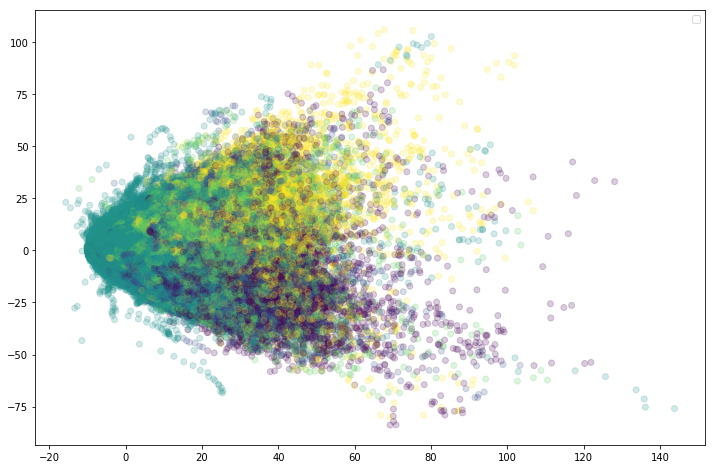

In [16]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(12,8))
plt.scatter(X_2d_pca['PCA_1'], X_2d_pca['PCA_2'], alpha=0.2, c=y, cmap='viridis')
plt.legend(X_2d_pca['PCA_1'], X_2d_pca['PCA_2'])
plt.show()

In [17]:
# plt.figure(figsize=(12,8))
# sns.lmplot('PCA_1', 'PCA_2', pd.concat([X_2d_pca, df['Target_HL']], axis=1), hue='Target_HL', fit_reg=False)
# fig = plt.gcf()
# fig.set_size_inches(15, 10)
# plt.show()

### SVD

In [18]:
svd = TruncatedSVD(n_components=2).fit(X_scaled)
X_2d_svd = pd.DataFrame(svd.transform(X_scaled)).rename(columns={0:'SVD_1', 1:'SVD_2'})
X_2d_svd.head()

,SVD_1,SVD_2
0,24.161549,34.969206
1,24.878482,36.022847
2,24.804772,35.930352
3,25.816691,39.137513
4,28.815748,42.613270


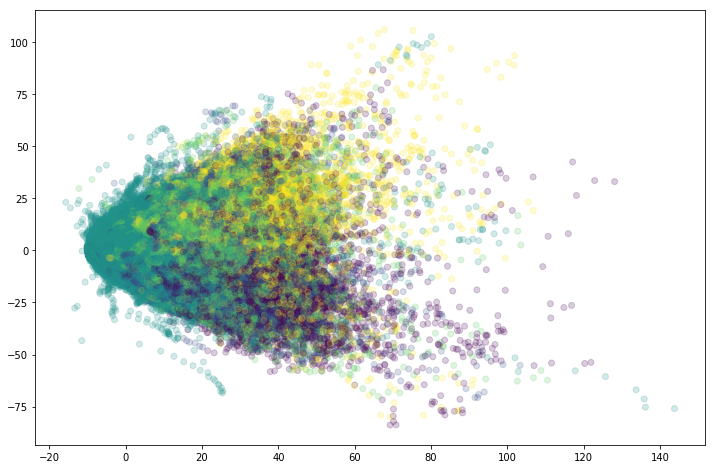

In [19]:
plt.figure(figsize=(12,8))
plt.scatter(X_2d_svd['SVD_1'], X_2d_svd['SVD_2'], alpha=0.2, c=df['Target_HL'], cmap='viridis')
plt.legend([0,1,2,3,4])
plt.show()

In [20]:
X_2d_pca.values == X_2d_svd.values

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [21]:
X_2d_pca.values - X_2d_svd.values

array([[-4.54630467e-09,  1.16242683e-06],
       [-5.65786351e-08,  1.39473517e-06],
       [-1.45226089e-07,  1.32628005e-06],
       ...,
       [ 5.23368300e-08,  6.45965437e-08],
       [ 1.05570008e-07, -2.75066276e-08],
       [ 5.37071472e-08, -8.88506912e-09]])

#### PCA and SVD found very similar values...

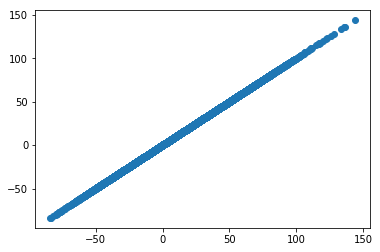

In [22]:
plt.scatter(X_2d_pca.values, X_2d_svd.values)

In [23]:
gc.collect()

4977

### t-SNE

In [27]:
X_embedded = TSNE(n_components=2).fit_transform(X_scaled.tail(10000))
X_embedded

array([[-59.91935 ,  20.51355 ],
       [-59.918182,  20.530664],
       [-62.448776,  13.667002],
       ...,
       [ 70.00201 , -29.39363 ],
       [ 69.89468 , -29.462543],
       [ 69.80717 , -29.540401]], dtype=float32)

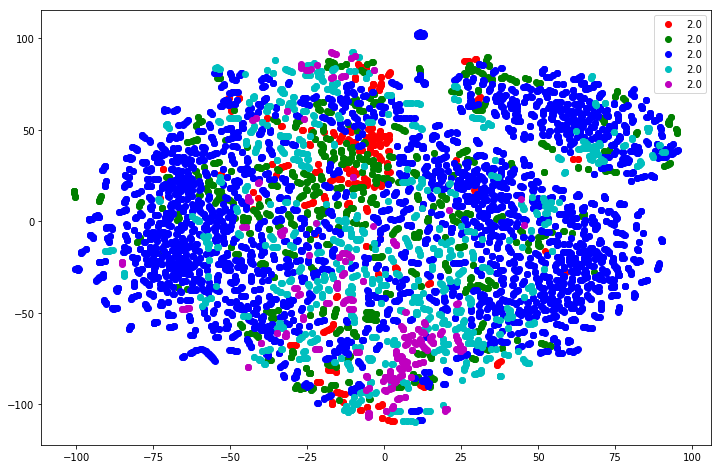

In [31]:
plt.figure(figsize=(12, 8))
colors = 'r', 'g', 'b', 'c', 'm'
for i, c, label in zip(range(len(y.tail(10000))), colors, y.tail(10000)):
    plt.scatter(X_embedded[y.tail(10000) == i, 0], X_embedded[y.tail(10000) == i, 1], c=c, label=label)
plt.legend([0,1,2,3,4])
plt.show()

In [38]:
X_embedded = TSNE(n_components=2, learning_rate=10, perplexity=200, 
                  early_exaggeration=50, init='pca', angle=.2, random_state=0).fit_transform(X_scaled.tail(10000))
X_embedded

array([[ -7.328435 ,   4.121797 ],
       [ -7.33106  ,   4.140145 ],
       [ -6.3549967,   4.1649995],
       ...,
       [ -0.5783569, -12.410544 ],
       [ -0.6189462, -12.420042 ],
       [ -0.6653075, -12.341914 ]], dtype=float32)

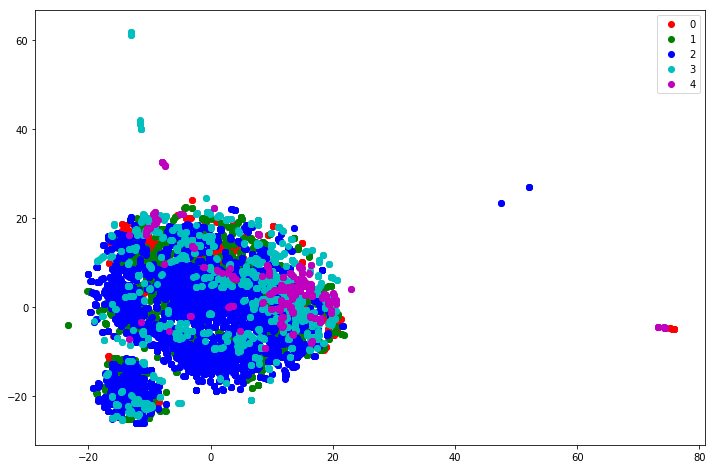

In [48]:
plt.figure(figsize=(12, 8))
colors = 'r', 'g', 'b', 'c', 'm'
for i, c, label in zip(range(len(y.tail(10000))), colors, y.tail(10000)):
    plt.scatter(X_embedded[y.tail(10000) == i, 0], X_embedded[y.tail(10000) == i, 1], c=c, label=label)
plt.legend([0,1,2,3,4])
plt.show()